# Miscellaneous data analysis and simulation topics

Here we will explore some miscellaneous topics: taking Fourier transforms, solving differential equations, and storing and loading objects to and from file.

We will follow best practices and write all of our `import`s at the beginning of the notebook. This makes it easy for the user to see what packages are needed to run this notebook.

In [1]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import pickle

## 1. Fourier transforms

Fourier transforms are a super important tool in science because they can separate out different frequencies from a signal. Let us generate two signals at different frequencies:

Text(0.5, 0, 'time')

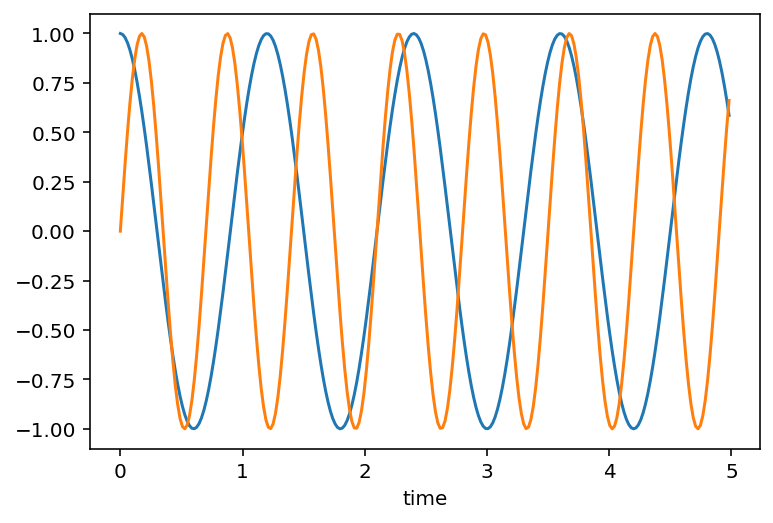

In [2]:
t_max = 5
t = np.linspace(0, t_max, 256, endpoint=False)

w1 = 2 * np.pi / 1.2
w2 = 2 * np.pi / 0.7

x1 = np.cos(w1 * t)
x2 = np.sin(w2 * t)

plt.plot(t, x1)
plt.plot(t, x2)

plt.xlabel("time")

Numpy can calculate the Discrete Fourier Transform (DFT) for us using a fast algorithm, usually known as the Fast Fourier Transform (FFT). We will not explain the Fourier transform in detail here, but this is one of the things that Wikipedia explains very well: [DFT](https://en.wikipedia.org/wiki/Discrete_Fourier_transform), [FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform). The thing to know is that the FFT of a signal of length $n$ is another length-$n$ vector, but this time *complex-valued*. The $k$th entry represents the complex coefficient of the complex oscillation with period $n / k$ – more precisely, it is the coefficient of the complex exponential $\exp(-2 \pi i k / n)$. When $k > n / 2$, *aliasing* occurs, such that index $k$ and index $n - k$ refer to the same oscillation, up to a complex-conjugate. If the original signal is real, the $n - k$th value of the FFT is equal to the complex conjugate of the $k$th value. We can see this in the absolute value of the FFT plotted below:

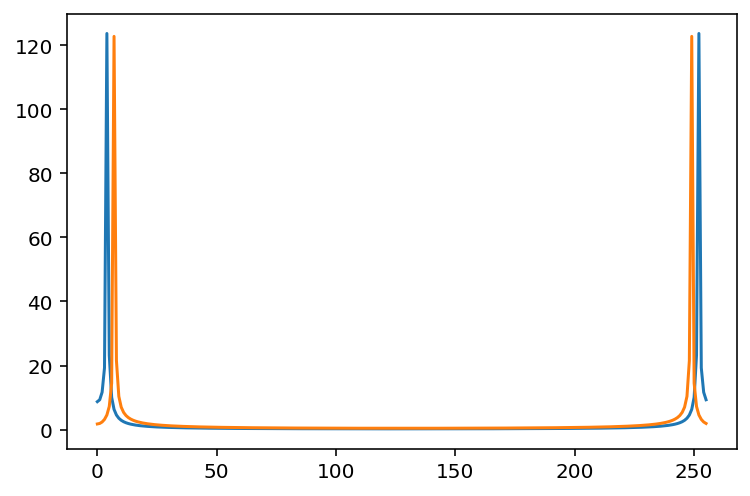

In [3]:
f1 = np.fft.fft(x1)
f2 = np.fft.fft(x2)

plt.plot(np.abs(f1))
plt.plot(np.abs(f2))

We can thus only show half of the FFT, since the other half is symmetric:

Text(0.5, 0, 'frequency')

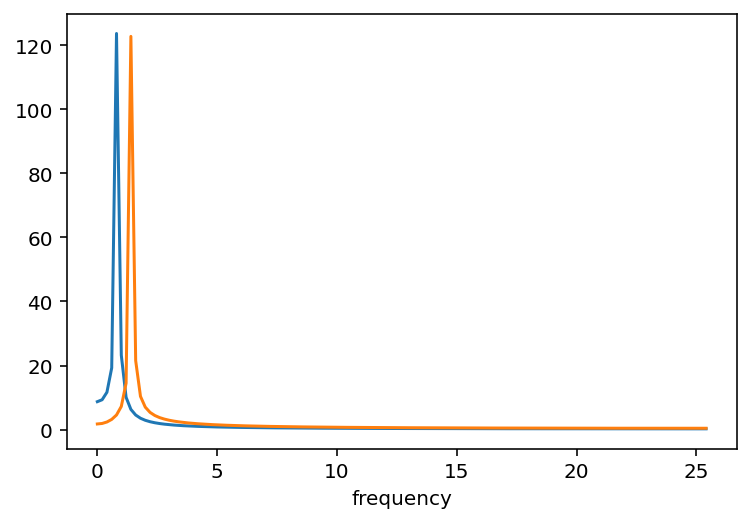

In [4]:
n = len(f1)
# // is integer division
half = (n + 1) // 2
plt.plot(np.arange(half) / t_max, np.abs(f1[:half]))
plt.plot(np.arange(half) / t_max, np.abs(f2[:half]))

plt.xlabel("frequency")

We also normalized the frequency axis above to match the time unit implied by our definition of `t` above.

Of course, picking out the frequency of a sinusoidal signal is not very impressive. The FFT can find the individual components even if we add up the signals:

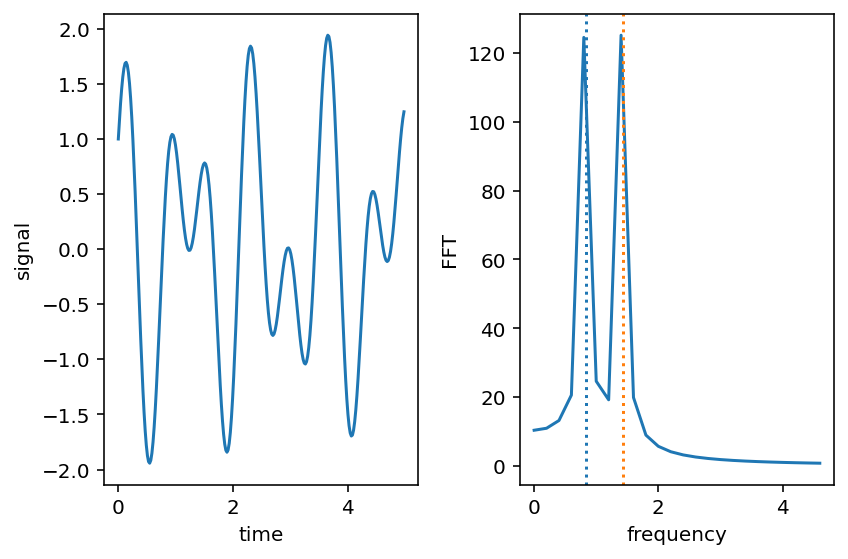

In [5]:
x = x1 + x2
f = np.fft.fft(x)

plt.subplot(121)
plt.plot(t, x)
plt.xlabel("time")
plt.ylabel("signal")

plt.subplot(122)
sub_range = 24
plt.plot(np.arange(sub_range) / t_max, np.abs(f[:sub_range]))
plt.axvline(w1 / (2 * np.pi), ls=":", c="C0")
plt.axvline(w2 / (2 * np.pi), ls=":", c="C1")
plt.xlabel("frequency")
plt.ylabel("FFT")

# this adjusts the plots to avoid overlapping
plt.tight_layout()

In the plot above, we zoomed into the lower-frequency part of the FFT spectrum, and indicated the known frequencies of the two signals using dotted lines. Note how the FFT correctly identified that the signal `x` is composed of two different frequencies, and identified these frequencies.

## 2. Differential equations

Differential equations are ubiquitous in physics – and in mathematical modeling more generally. All but a handful of differential equations have no analytical solutions, and so it is essentially to be able to solve the numerically. Fortunately, a companion package to Numpy – Scipy – has functions that can do this for us.

Let us consider here the example of a pendulum of length $\ell$ in a uniform gravitational field of strength $g$. If we denote the angle of the pendulum by $\theta$, the equation of motion is
$$\ddot \theta = -\frac g {\ell} \sin \theta \,.$$
We write a function that calculates the time evolution of the pendulum angle when the pendulum is started at $\theta(0) = 0$ with an initial angular velocity $\dot\theta(0) = \omega_0$. For simplicity we work in units where $g / \ell = 1$.

The function that we need to use to integrate ordinary differential equations (ODEs) is `scipy.integrate.solve_ivp`. This function solves differential equations of the form
$$\frac {dy} {dt} = f(t, y)\,.$$
Our equation can be placed in that form by defining the angular velocity $\omega = \dot \theta$; we then define
$$y \equiv (y_0, y_1) = (\theta, \omega)\,,$$
and we have
$$\dot y = (\dot\theta, \dot\omega) = (\omega, - \sin\theta) = (y_1, -\sin y_0)\,.$$

In [6]:
def pendulum(omega0, t_max, n=200):
    """Integrate the equation of motion for a pendulum starting at zero angle.
    
    :param omega0: initial angular velocity
    :param t_max: total integration time
    :param n: number of evaluation points
    :return: the results structure from `solve_ivp`
    """
    # a "lambda" is an anonymous function; the syntax is fairly intuitive: the lambda
    # below takes in two arguments, t and y, and returns a list with two elements,
    # y[1] and -np.sin(y[0])
    # note that t is provided by solveivp so we need it in the function definition, but
    # we do not actually use it
    results = integrate.solve_ivp(
        lambda t, y: [y[1], -np.sin(y[0])],
        [0, t_max],         # integration range
        [0, omega0],        # initial conditions: theta = 0, omega = omega0
        t_eval=np.linspace(0, t_max, n),    # points where to evaluate solution
    )
    
    return results

By the way, the string immediately following the `def` statement is a documentation string, or "docstring". Python displays this string when we ask for help about a function:

In [ ]:
help(pendulum)

Help on function pendulum in module __main__:

pendulum(omega0, t)
    Integrate the equation of motion for a pendulum starting at zero angle.
    
    :param omega0: initial angular velocity
    :param t: total integration time.
    :return:



The triple quotation marks representa multi-line string – notice how the docstring spreads over several lines, unlike normal strings, which cannot contain line breaks.

Let's see our function in action.

In [7]:
# solve the equations for a small initial speed
slow = pendulum(0.5, 20.0)

# solve the equations for a large initial speed
fast = pendulum(1.5, 20.0)

The object returned by `solve_ivp` (and thus, by our `pendulum` function) contains various information, such as whether the algorithm converged, the number of iterations it needed, etc. It also contains the series of times and `t` and corresponding function values `y` – this is the solution to the problem.

In [8]:
slow

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 146
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0.        ,  0.10050251,  0.20100503,  0.30150754,  0.40201005,
        0.50251256,  0.60301508,  0.70351759,  0.8040201 ,  0.90452261,
        1.00502513,  1.10552764,  1.20603015,  1.30653266,  1.40703518,
        1.50753769,  1.6080402 ,  1.70854271,  1.80904523,  1.90954774,
        2.01005025,  2.11055276,  2.21105528,  2.31155779,  2.4120603 ,
        2.51256281,  2.61306533,  2.71356784,  2.81407035,  2.91457286,
        3.01507538,  3.11557789,  3.2160804 ,  3.31658291,  3.41708543,
        3.51758794,  3.61809045,  3.71859296,  3.81909548,  3.91959799,
        4.0201005 ,  4.12060302,  4.22110553,  4.32160804,  4.42211055,
        4.52261307,  4.62311558,  4.72361809,  4.8241206 ,  4.92462312,
        5.02512563,  5.12562814,  5.22613065,  5.32663317,  5.42713568,
        5.52763819,  5.628140

Hmm, this will be easier to understand with a plot:

Text(0, 0.5, 'angle')

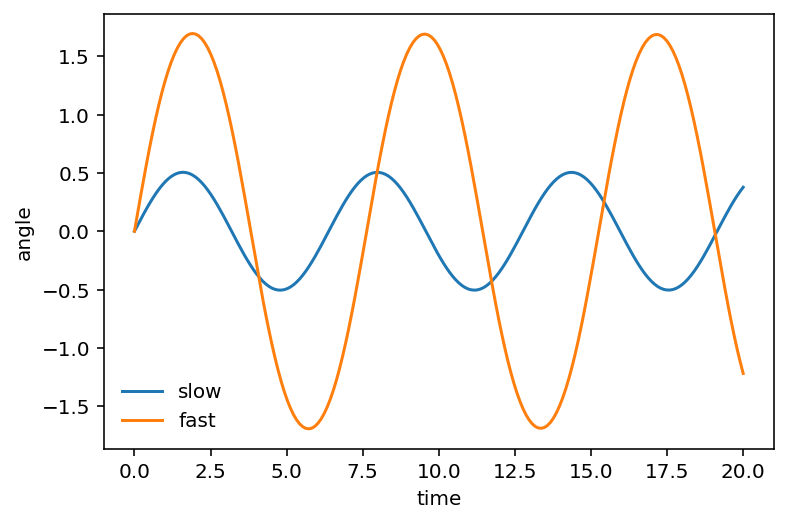

In [9]:
plt.plot(slow.t, slow.y[0], label="slow")
plt.plot(fast.t, fast.y[0], label="fast")
plt.legend(frameon=False)
plt.xlabel("time")
plt.ylabel("angle")

Remember that here "slow" and "fast" refer to the initial velocity; in terms of oscillation frequency, the "fast" trajectory actually oscillates more slowly because it has higher amplitude.

For fun, let's use this function to make a phase portrait for the pendulum. A phase portrait is a plot of the coordinates of a dynamical system – in this case the angle $\theta$ and angular velocity $\omega$ – versus each other.

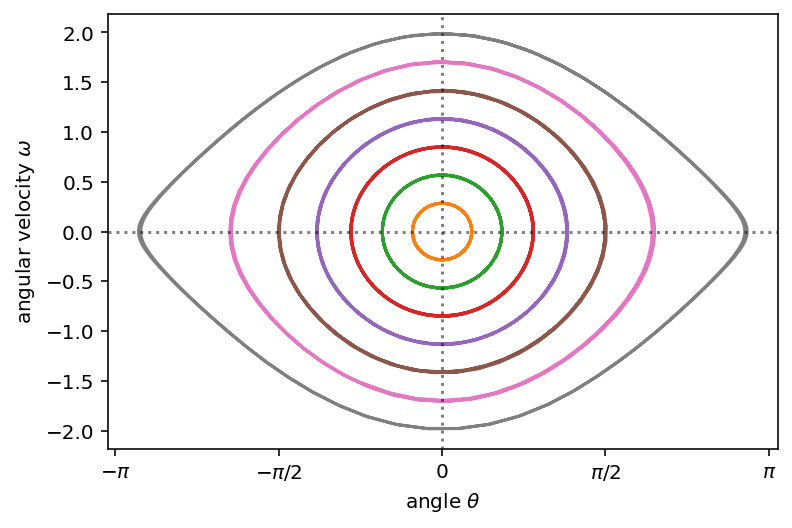

In [10]:
omega0_values = np.linspace(0, 1.99, 8)
t_max = 30.0
for omega0 in omega0_values:
    crt_soln = pendulum(omega0, t_max)
    plt.plot(crt_soln.y[0], crt_soln.y[1])

plt.xlabel(r"angle $\theta$")
plt.ylabel(r"angular velocity $\omega$")

plt.xticks(
    [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi],
    labels=[r"$-\pi$", r"$-\pi / 2$", "0", r"$\pi / 2$", r"$\pi$"],
)

plt.axhline(0, c="k", ls=":", alpha=0.5)    # alpha = opacity
plt.axvline(0, c="k", ls=":", alpha=0.5)

## 3. "Pickling" data

It is sometimes necessary to keep the results of a computation – for example if it took a long time to generate. There are different ways to save such results to file in Python. One option would be to use Pandas as store the data as, for example, a `.csv` file. A different approach, suitable for large and complex datasets, is using the hierarchical data format (HDF). This can be done using the `hdf5` package, and we encourage you to take a look at the documentation: https://docs.h5py.org/en/stable/.

Here we focus on a third method, which actually comes with the standard set of Python packages: "pickling". Pickles are files that can contain almost arbitrary Python objects. This is both an advantage and a disadvantage: the fact that almost anything can be pickled means that you don't need to spend a lot of time figuring out how to store and restore your results to file; but the flexibility of pickles makes them a potential security hazard: it is possible to craft a pickle that runs arbitrary code on your computer. It is therefore very important to avoid opening pickle files from untrusted sources. Pickles are best used as a local storage tool rather than a storage solution meant to be shared with others.

OK, disclaimers aside: how do we pickle? And how do we unpickle? The process is pretty easy; let's store our `slow` pendulum solution to a file:

In [11]:
# this opens the file with the given name for writing (w) in binary (b) format, calling
# the resulting open file object `f`; the file is automatically closed at the end of the
# block following the `with` statement
with open("save/slow_pendulum.pkl", "wb") as f:
    pickle.dump(slow, f)

That's it! Now we have the solution pickled! Let's check that this worked by unpickling:

In [12]:
with open("save/slow_pendulum.pkl", "rb") as f:     # note "r" for read here!
    slow_reloaded = pickle.load(f)

Indeed, the two solutions are the same:

In [13]:
np.allclose(slow_reloaded.y, slow.y)

True

## 4. Links to more advanced topics

We've said this before and we'll say it again: you're well on your way to writing complex applications in Python! But also, there's a lot of stuff left to learn. Here are some pointers and links for some more advanced topics:

1. Python can be slow. This is because it is a very flexible language: the type of a variable can, for instance, change at any point during the execution of the program, prohibiting many useful optimizations. Other languages, like C or C++, can be much faster, but they have a much steeper learning curve and it takes longer to write code in them. Wouldn't it be great if you could combine the two? It turns out that you can!
* the hard way: you can write a C or C++ extension module that you can then import into Python; https://docs.python.org/3.9/extending/extending.html
* the easier way: you can use a package such as `numba` to accelerate Python code, provided some restrictions are obeyed; https://numba.pydata.org/
* another way: use a just-in-time (JIT) implementation of the Python interpreter; https://www.pypy.org/

2. Parallel computing. Python code typically runs in a linear fashion, with one command following the previous. Sometimes it is possible to write code such as several different lines of computation run in parallel, which can greatly accelerate the code. Modern computers have multiple computation cores per CPU and even multiple CPUs, which means parallel computing can even accelerate code running on a single machine.
* the built-in way: the `multiprocessing` module allows for parallelism; most easily used on a single machine; https://docs.python.org/3/library/multiprocessing.html
* the Message Passing Interface (MPI) is a standard way of implementing parallel code across multiple machines; https://www.nesi.org.nz/sites/default/files/mpi-in-python.pdf

3. Markov-chain Monte Carlo simulations. Oftentimes we work with stochastic models that define a probability distribution over a certain solution set. If the target space is high-enough dimensional, sampling methods are usually employed for navigating this space. This is particularly useful in [Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference).
* a package that is very easy to use is `emcee`; fun fact: it is mainly developed by Daniel Foreman-Mackey an Associate Research Scientist here at the Center for Computational Astrophysics at Flatiron; https://emcee.readthedocs.io/en/stable/
* a widely used platform for statistical modeling is Stan, which has a thin Python wrapper `pystan`; https://pystan.readthedocs.io/en/latest/